In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/ludo/ownCloud/Programmes/quarto/Fisher-KPP/Fisher-KPP"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using MethodOfLines, ModelingToolkit, DomainSets, OrdinaryDiffEq, Plots, LaTeXStrings

In [3]:
@parameters t, x

2-element Vector{Num}:
 t
 x

In [4]:
@variables u(..)

1-element Vector{Symbolics.CallWithMetadata{SymbolicUtils.FnType{Tuple, Real}, Base.ImmutableDict{DataType, Any}}}:
 u⋆

In [5]:
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

Differential(x) ∘ Differential(x)

In [6]:
r = 1.0
D = 1.0

1.0

In [7]:
#| output: true
eq = Dt(u(t, x)) ~ r * u(t,x) * (1-u(t,x)) + D * Dxx(u(t,x))

Differential(t)(u(t, x)) ~ (1 - u(t, x))*u(t, x) + Differential(x)(Differential(x)(u(t, x)))

In [8]:
x_max = 30.0
t_max = 14.0

14.0

In [9]:
domain = [x ∈ Interval(0.0, x_max),
          t ∈ Interval(0.0, t_max)]

2-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, 0.0..30.0)
 Symbolics.VarDomainPairing(t, 0.0..14.0)

In [10]:
ic_bc = [u(0.0, x) ~ 0.0,
         u(t, 0.0) ~ 1.0,
         u(t, x_max) ~ 0.0]

3-element Vector{Equation}:
 u(0.0, x) ~ 0.0
 u(t, 0.0) ~ 1.0
 u(t, 30.0) ~ 0.0

In [11]:
@named sys = PDESystem(eq, ic_bc, domain, [t, x], [u(t,x)])

PDESystem
Equations: Equation[Differential(t)(u(t, x)) ~ (1 - u(t, x))*u(t, x) + Differential(x)(Differential(x)(u(t, x)))]
Boundary Conditions: Equation[u(0.0, x) ~ 0.0, u(t, 0.0) ~ 1.0, u(t, 30.0) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0..30.0), Symbolics.VarDomainPairing(t, 0.0..14.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [12]:
dx = 0.1
discretization = MOLFiniteDifference([x => dx], t)

MOLFiniteDifference{MethodOfLines.CenterAlignedGrid, MethodOfLines.ScalarizedDiscretization}(Dict{Num, Float64}(x => 0.1), t, 2, UpwindScheme(1), MethodOfLines.CenterAlignedGrid(), true, false, MethodOfLines.ScalarizedDiscretization(), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [13]:
prob = discretize(sys, discretization)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 14.0)
u0: 299-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [14]:
sol = solve(prob, Tsit5(), saveat = .1)

retcode: Success
Interpolation: Dict{Num, Interpolations.GriddedInterpolation{Float64, 2, Matrix{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}}}}
t: 141-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  1.0
  1.1
  1.2
  ⋮
 12.9
 13.0
 13.1
 13.2
 13.3
 13.4
 13.5
 13.6
 13.7
 13.8
 13.9
 14.0ivs: 2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 t
 xdomain:([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0], 0.0:0.1:30.0)
u: Dict{Num, Matrix{Float64}} with 1 entry:
  u(t, x) => [1.0 0.0 … 0.0 0.0; 1.0 0.827388 … 0.0 0.0; … ; 1.0 1.00001 … 0.00…

In [15]:
gridx = sol[x]
gridt = sol[t]
solu = sol[u(t,x)]

141×301 Matrix{Float64}:
 1.0  0.0       0.0       0.0       …   0.0            0.0           0.0
 1.0  0.827388  0.662634  0.511867      0.0            0.0           0.0
 1.0  0.881019  0.764278  0.652127      0.0            0.0           0.0
 1.0  0.905508  0.812027  0.72059       0.0            0.0           0.0
 1.0  0.920511  0.8415    0.763612      3.47498e-179   1.56655e-180  0.0
 1.0  0.930984  0.862228  0.794054  …   3.38938e-132  -3.34521e-133  0.0
 1.0  0.93889   0.877911  0.817232     -2.74069e-104   4.94008e-105  0.0
 1.0  0.945167  0.890366  0.835741     -2.29488e-87    5.52327e-88   0.0
 1.0  0.950312  0.900635  0.850977      4.98836e-76   -1.43772e-76   0.0
 1.0  0.954659  0.909285  0.863888     -4.54618e-67    1.48948e-67   0.0
 1.0  0.958395  0.916727  0.875014  …  -2.26126e-60    8.01703e-61   0.0
 1.0  0.961647  0.923251  0.884717      5.32389e-55   -2.00331e-55   0.0
 1.0  0.964536  0.928991  0.893352     -1.77764e-50    7.0251e-51    0.0
 ⋮                        

[ Info: Saved animation to /home/ludo/ownCloud/Programmes/quarto/Fisher-KPP/Fisher-KPP/fisherKPP.gif


Plots.AnimatedGif("/home/ludo/ownCloud/Programmes/quarto/Fisher-KPP/Fisher-KPP/fisherKPP.gif")
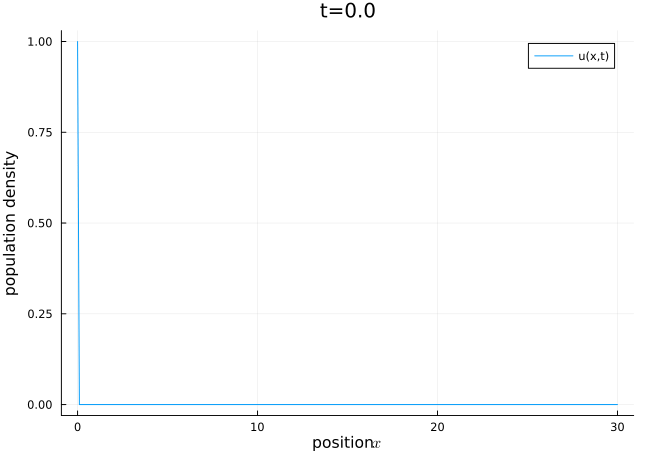

In [16]:
#| output: true
anim = @animate for i in eachindex(gridt)
    plot(gridx, solu[i, :],
    xlabel = "position"*L"$x$",
    ylabel = "population density", 
    label = "u(x,t)", 
    title = "t=$(gridt[i])")
end

gif(anim, "fisherKPP.gif", fps = 10)